# Obtain model onset prediction

In [256]:
import pickle
import os
import numpy as np
import glob

import warnings # ignore tensorflow warinings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

from keras import backend as K
from large_vocab_adt_dafx2018.transcribe import transcribe, PERC_VOICE_SET
import soundfile as psf

import sys
sys.path.append('large_vocab_adt_dafx2018')
import large_vocab_adt_dafx2018.model as model


In [257]:
from utils import read_audio
input_audio_file = '1_rock_87_beat_4-4.wav'
x,sr= read_audio('1_rock_87_beat_4-4.wav')
print(len(x)/sr)

# Model 303 is the Small, Multi-task model trained on real + synth, with classes weighted by entropy
#
# Other models:
# MT-S-R (289)
# MT-S-S (290)
# MT-S-R+S (291)
# MT-L-R (292)
# MT-L-S (293)
# MT-L-R+S (294)
# 14VST-S-R+S (295)
# 3VST-S-R+S (301)
# BTST-S-R+S (302)
# 14VST-S-R+S-Eweight (303)
model_definition_path = 'large_vocab_adt_dafx2018/trained_models/303_s0_def.json'
model_weights_path = 'large_vocab_adt_dafx2018/trained_models/303_s0_weights.h5'
model_configuration_id = 303
sample_audio_files = dict([(v, os.path.join('audio/', '{}.wav'.format(v))) for v in PERC_VOICE_SET])

57


In [258]:
# compute model's onsets >> outputs 14 voices
output = transcribe(model_definition_path,
                    model_weights_path,
                    input_audio_file,
                    model_configuration_id,
                    sample_audio_files,
                    peak_params=None,
                    output_sample_rate=44100)

model_14v = output['14v']['onset_activations']

Single output


Since the model outputs 14 voices, we need to reduce them to the 8 ones present in the magenta dataset. In the magenta dataset there's actually 9 but one has no correspondence with the ones that this model outputs, so I removed it

In [259]:
# reduce 14 voices to the 8 present in the magenta dataset

length_in_samples = model_14v.shape[0]
model_8v = np.zeros([timefrs,8])

reduced_mapping = {
    0: [0],     # kick
    1: [1,2],   # snare + snare rim 
    2: [3],     # crash
    3: [4,12],  # ride + bell
    4: [5],     # open hh
    5: [6],     # closed hh
    6: [7,8],   # low+mid tom
    7: [9]      # high tom
}


eps = 0 #threshold ?
for t in range(timefrs):
    t_roll = model_14v[t,:]
    t_roll[t_roll<eps] = 0
    for i in reduced_mapping.keys():
        model_8v[t,i] = np.max(t_roll[reduced_mapping[i]])

In [260]:
"""
failing
# reduce 14 voices to the 8 present in the magenta dataset

length_in_samples = model_14v.shape[0]
model_8v = np.zeros([timefrs,8])

reduced_mapping = {
    "kick": [0,[0]],     # kick
    "snare": [1,[1,2]],   # snare + snare rim 
    "crash": [2,[3]],     # crash
    "ride": [3,[4,12]],  # ride + bell
    "open_hh": [4,[5]],     # open hh
    "closed_hh": [5,[6]],     # closed hh
    "low_mid_tom": [6,[7,8]],   # low+mid tom
    "high_tom": [7,[9]]      # high tom
}


eps = 0 #threshold ?
for t in range(timefrs):
    t_roll = model_14v[t,:]
    t_roll[t_roll<eps] = 0
    for i,inst in enumerate(reduced_mapping.keys()):
        model_8v[t,i] = np.max(t_roll[reduced_mapping[inst][1]])

"""

'\nfailing\n# reduce 14 voices to the 8 present in the magenta dataset\n\nlength_in_samples = model_14v.shape[0]\nmodel_8v = np.zeros([timefrs,8])\n\nreduced_mapping = {\n    "kick": [0,[0]],     # kick\n    "snare": [1,[1,2]],   # snare + snare rim \n    "crash": [2,[3]],     # crash\n    "ride": [3,[4,12]],  # ride + bell\n    "open_hh": [4,[5]],     # open hh\n    "closed_hh": [5,[6]],     # closed hh\n    "low_mid_tom": [6,[7,8]],   # low+mid tom\n    "high_tom": [7,[9]]      # high tom\n}\n\n\neps = 0 #threshold ?\nfor t in range(timefrs):\n    t_roll = model_14v[t,:]\n    t_roll[t_roll<eps] = 0\n    for i,inst in enumerate(reduced_mapping.keys()):\n        model_8v[t,i] = np.max(t_roll[reduced_mapping[inst][1]])\n\n'

# Midi to format

In [261]:
import pretty_midi
midi_data = pretty_midi.PrettyMIDI('1_rock_87_beat_4-4.mid')
input_audio_file = '1_rock_87_beat_4-4.wav'
onsets = midi_data.get_onsets()

In [262]:
# get pretty_midi Notes objects in a list
drums_notes = midi_data.instruments[0].notes[:]

drums_onsets = []
drums_pitches = []

for note in drums_notes:
    drums_onsets.append(note.start)
    drums_pitches.append(note.pitch)

drums_onsets = np.round(drums_onsets,2)


In [263]:
# transform to match format
# mapear onsets a samples
frmTime = hop_length*np.arange(length_in_samples)/float(sr); 
onsets_in_samples = np.round(drums_onsets/0.01,0)

# mapear pitches al set reducido 
magenta_mapping = { # [key, [pitches]]
    "kick":[0,[36]],
    "snare":[1,[38,40,37]],
    "crash":[2,[49,55,57,52]],
    "ride":[3,[51,59,53]],
    "open_hh":[4,[46,26]],
    "closed_hh":[5,[42,22,44]],
    "low_mid_tom":[6,[45,47]],
    "high_tom":[7,[48,50]]
}

magenta_transcription = np.zeros([length_in_samples,8])

for onset,pitch in zip(onsets_in_samples,drums_pitches):
    onset = int(onset)
    for inst in magenta_mapping.keys():
        if pitch in magenta_mapping[inst][1]:
            magenta_transcription[onset][magenta[inst][0]] = 1

# Plot

In [264]:
import matplotlib.pyplot as plt
import librosa.display

%matplotlib inline

def plot_activations(X, voice_type, start_s, stop_s, sample_interval, sr=44100, size=(15,5)):
    sample_interval = int(round(sample_interval * sr)) / float(sr)
    hop_length = int(sample_interval * sr)
    start_idx = int(start_s / sample_interval)
    stop_idx = int(stop_s / sample_interval)
    plt.figure(figsize=size)
    print(X.shape)
    librosa.display.specshow(X[start_idx:stop_idx,:].T, 
                             sr=sr, 
                             hop_length=hop_length,
                             x_axis='time')
    
    if voice_type == 'full':
        labels = ['Kick Drum',
                  'Snare',
                  'Snare Rim',
                  'Crash',
                  'Ride',
                  'Open Hi-Hat',
                  'Closed Hi-Hat',
                  'Low Tom',
                  'Mid Tom',
                  'High Tom',
                  'Conga / Bongo',
                  'Clap',
                  'Bell',
                  'Clave']
        
    elif voice_type == 'reduced':
        labels = ['Kick Drum', # 0
                  'Snare', # 1 Snare + Snare Rim
                  'Crash', # 2
                  'Ride', # 3 Ride + Bell
                  'Open Hi-Hat', # 4
                  'Closed Hi-Hat', # 5
                  'Low-Mid Tom', # 6 Low + Mid
                  'High Tom'] # 7
    else:
        labels = ['Kick Drum',
                  'Snare',
                  'Hi-Hat']        
    plt.yticks(np.arange(X.shape[1]) + 0.5, labels)

# Plot activations

In [265]:
#plot_activations(output['14v']['onset_activations'], 'full', 0, 10, 0.01)

[0.00239161 0.00049933 0.00040749 ... 0.00048659 0.00039668 0.0009244 ]
(5780, 8)


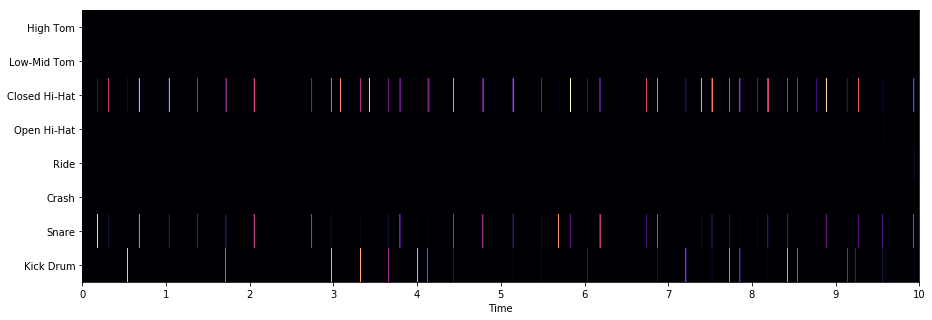

In [266]:
print(model_8v[:,0])
plot_activations(model_8v,'reduced', 0, 10, 0.01)

(5780, 8)


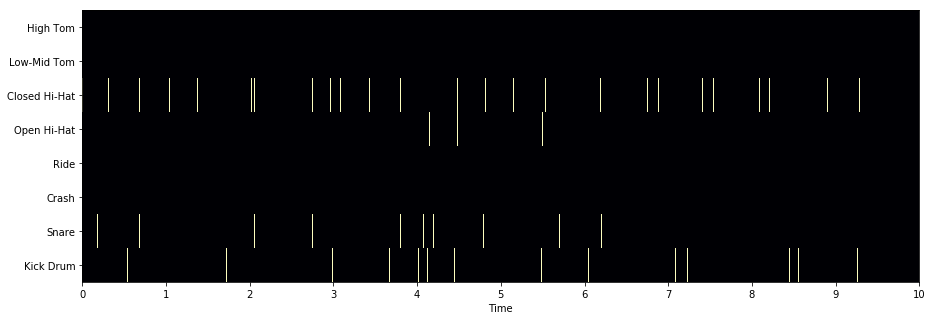

In [267]:
plot_activations(magenta_transcription,'reduced',0,10,0.01)

# Evaluation
para hacer la evaluación hay q pasar un array de los onsets en segundos

In [281]:
import mir_eval
onsets_eval_magenta = np.arange(length_in_samples)*magenta_transcription[:,0]*0.01
#model_8v[model_8v<0.5] = 0
#model_8v = model_8v[model_8v!=0]
simp_model = model_8v;
simp_model[simp_model<0.01] = 0

onsets_eval_magenta = np.sort(onsets_eval_magenta[onsets_eval_magenta!=0])

onsets_eval_model = np.arange(length_in_samples)*simp_model[:,0]*0.01
onsets_eval_model = np.sort(onsets_eval_model[onsets_eval_model!=0])
print(len(onsets_eval_model),len(onsets_eval_magenta))
print(onsets_eval_model[0:100])
mir_eval.onset.validate(onsets_eval_magenta,onsets_eval_model)
mir_eval.onset.f_measure(onsets_eval_magenta,onsets_eval_model, window=0.05)

(36, 91)
[ 0.43218608  0.98040895  2.24367612  2.50780967  2.96283032  4.89415155
  4.93356694  5.94546473  6.52292229  8.98145752  9.46796876  9.95104163
 10.74262218 13.08444189 13.3507053  13.6016643  15.9678551  18.12746085
 18.20073486 19.2643548  20.67454075 20.80247129 21.34856056 22.52797204
 23.87943531 26.65698599 27.08815178 28.0797875  29.80735372 31.78906928
 32.23063384 37.13218966 40.24977576 40.28043685 41.2317795  42.76134685]


(0.07874015748031496, 0.1388888888888889, 0.054945054945054944)